# SWIFT-HEP / GridPP Workshop - April 2025

## Caching

The Dirac Client is introduced here.
Functionally it works the same as the dask.distributed.Client, but allows for persistent caching.

The following cache locations are supported:
- `local`: to set the directory use `file:///path/to/cache`

Caching options in the works;
- `rucio`: to set the directory use `rucio:///path/to/cache`
- `dirac`: to set the directory use `dirac:///path/to/cache`

In [ ]:
from dask_dirac import DiracClient
from dask.distributed import LocalCluster, Client
import dask.array as da

In [2]:
cluster = LocalCluster(n_workers=2)

DEBUG:asyncio:Using selector: EpollSelector


In [ ]:
client = DiracClient(cluster, cache_location="file:///tmp/dask-cache_05022025")
# client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 6,Total memory: 15.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:30633,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 15.14 GiB
Comm: tcp://127.0.0.1:21795,Total threads: 3
Dashboard: http://127.0.0.1:26169/status,Memory: 7.57 GiB
Nanny: tcp://127.0.0.1:30542,


DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tpng']


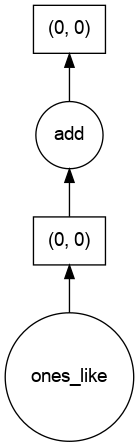

In [15]:
# Create a Dask DataFrame directly
dask_array = da.ones((1, 1), chunks=(1)) + 20231
dask_array.visualize()

In [16]:
result = client.compute(dask_array)

DEBUG:root:Input dask graph:
{'finalize-9ee9b572c7b6432bfee21436aa037c15': (<function finalize at 0x7f59f910b7f0>, [[('add-cac1c16624f7c3bb02767500c0263c3b', 0, 0)]]), ('add-cac1c16624f7c3bb02767500c0263c3b', 0, 0): (subgraph_callable-d80cf951f510c60c77d3daada7fbdecb, 20231, (1, 1))}
---------
performing caching checks
---------
DEBUG:root:Key: ('add-cac1c16624f7c3bb02767500c0263c3b', 0, 0), Value: (subgraph_callable-d80cf951f510c60c77d3daada7fbdecb, 20231, (1, 1))
DEBUG:root:Checking if tmp_keys: dict_keys([]), are in (subgraph_callable-d80cf951f510c60c77d3daada7fbdecb, 20231, (1, 1))
DEBUG:root:left: subgraph_callable-d80cf951f510c60c77d3daada7fbdecb
DEBUG:root:right: (20231, (1, 1))
DEBUG:root:rerunning function...
left: subgraph_callable-d80cf951f510c60c77d3daada7fbdecb
right: (20231, (1, 1))
DEBUG:root:left: 20231
DEBUG:root:right: (1, 1)
DEBUG:root:rerunning function...
left: 20231
right: (1, 1)
DEBUG:root:left: 1
DEBUG:root:right: 1
DEBUG:root:hash inputs: (1, 1)
hash inputs: 1 

In [17]:
result.result()

,col_0
0,20232.0


2025-02-05 13:29:40,791 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:17263' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'finalize-9ee9b572c7b6432bfee21436aa037c15'} (stimulus_id='handle-worker-cleanup-1738762180.7917821')


## GPU vs CPU

Function decorating with numba is introduced.
This is to highlight how GPUs can be utilized on the grid when they are available.

In [1]:
import awkward as ak
import numpy as np
import numba as nb
from dask_dirac import DiracClient
from dask.distributed import LocalCluster, Client

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

# import scipy.stats as s
import sys
import os
from scipy.special import erf, erfc
import random
import uproot as up
import tqdm

In [6]:
file = "/shared/scratch/ak18773/lz/mssi/SS_skim_Th232-late_HVInnerCone.root"

branches = [
    "ss.correctedS1Area_phd",
    "ss.correctedS2Area_phd",
    "ss.s1Area_phd",
    "ss.s2Area_phd",
    "ss.x_cm",
    "ss.y_cm",
    "ss.driftTime_ns",
]
mcBranches = [
    "mcTruthVertices.nRQMCTruthVertices",
    "mcTruthVertices.electricFieldStrength_Vcm",
    "mcTruthVertices.detectedS1Photons",
    "mcTruthVertices.detectedS2Photons",
    "mcTruthVertices.rawS1Photons",
    "mcTruthVertices.rawS2Photons",
    "mcTruthVertices.volumeName",
    "mcTruthVertices.positionX_mm",
    "mcTruthVertices.positionY_mm",
    "mcTruthVertices.positionZ_mm",
    "mcTruthVertices.energyDep_keV",
    "mcTruthVertices.pid",
    "mcTruthEvent.parentParticle",
    "mcTruthEvent.parentPositionX_mm",
    "mcTruthEvent.parentPositionY_mm",
    "mcTruthEvent.parentPositionZ_mm",
]

t = up.open(file)["Scatters"]
mct = up.open(file)["RQMCTruth"]

ss = t.arrays(branches)
mc = mct.arrays(mcBranches)

print(len(ss["ss.correctedS1Area_phd"]), len(mc["mcTruthVertices.nRQMCTruthVertices"]))

84923 84923


Done!


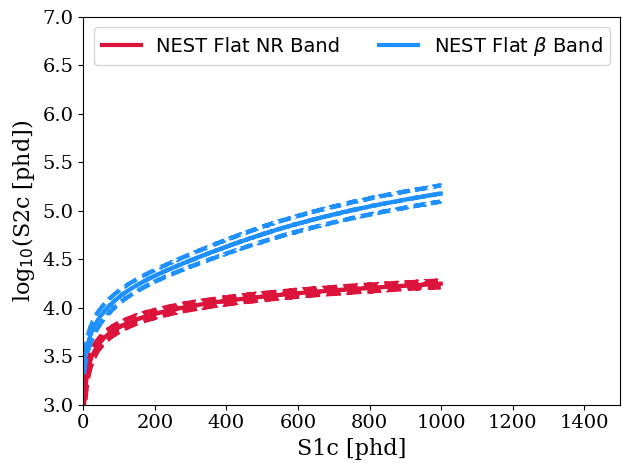

In [5]:
# get ER and NR band files:

bandPath = "/shared/scratch/ak18773/lz/mssi/"
betaBandFile = [
    line.rstrip() for line in open(bandPath + "flatBeta_SR3_logS2_gaussian_band.txt")
]
# betaBandFile = [line.rstrip() for line in open("/global/cfs/cdirs/lz/users/grischbi/CommissioningBands/generation/v3/BandMaker/flatBeta_SR1_logS2_skew_band.txt")]

nrBandFile = [
    line.rstrip() for line in open(bandPath + "flatNR_SR3_logS2_gaussian_band.txt")
]

xER, yER, yHiER, yLoER = [], [], [], []
xBR, yBR, yHiBR, yLoBR = [], [], [], []
xBRo, yBRo, yHiBRo, yLoBRo = [], [], [], []
xGR, yGR, yHiGR, yLoGR = [], [], [], []


for i in range(1, len(nrBandFile)):
    templist = nrBandFile[i].split()
    xGR.append(float(templist[0]))
    yGR.append(float(templist[1]))
    try:
        yHiGR.append(float(templist[1]) + float(templist[3][:-1]))
        yLoGR.append(float(templist[1]) - float(templist[2][1:]))
    except:
        yHiGR.append(float(templist[1]) + float(templist[2]))
        yLoGR.append(float(templist[1]) - float(templist[2]))

for i in range(1, len(betaBandFile)):
    templist = betaBandFile[i].split()
    xBR.append(float(templist[0]))
    yBR.append(float(templist[1]))
    try:
        yHiBR.append(float(templist[1]) + float(templist[3][:-1]))
        yLoBR.append(float(templist[1]) - float(templist[2][1:]))
    except:
        yHiBR.append(float(templist[1]) + float(templist[2]))
        yLoBR.append(float(templist[1]) - float(templist[2]))


def plotNR(label):
    if label == True:
        plt.plot(xGR, yGR, color="crimson", lw=3, label=r"NEST Flat NR Band")
    else:
        plt.plot(xGR, yGR, color="crimson", lw=3)
    # plt.fill_between( xGR, yLoGR, yHiGR, color='g', alpha=0.5 )
    plt.plot(xGR, yHiGR, color="crimson", linestyle="dashed", lw=3)
    plt.plot(xGR, yLoGR, color="crimson", linestyle="dashed", lw=3)


def plotBeta(label):
    if label == True:
        plt.plot(xBR, yBR, color="dodgerblue", lw=3, label=r"NEST Flat $\beta$ Band")
    else:
        plt.plot(xBR, yBR, color="dodgerblue", lw=3)
    # plt.fill_between( xNR, yLoNR, yHiNR, color='r', alpha=0.5 )
    plt.plot(xBR, yHiBR, color="dodgerblue", linestyle="dashed", lw=3)
    plt.plot(xBR, yLoBR, color="dodgerblue", linestyle="dashed", lw=3)


print("Done!")

plotNR(True)
plotBeta(True)
plt.xlim(0, 1500)
plt.ylim(3.0, 7.0)
plt.legend(loc="best", fontsize=14, ncol=2)
plt.xlabel("S1c [phd]", fontsize=16, family="serif")
plt.ylabel(r"log$_{10}$(S2c [phd])", fontsize=16, family="serif")
plt.xticks(size=14, family="serif")
plt.yticks(size=14, family="serif")
plt.tight_layout()
plt.show()

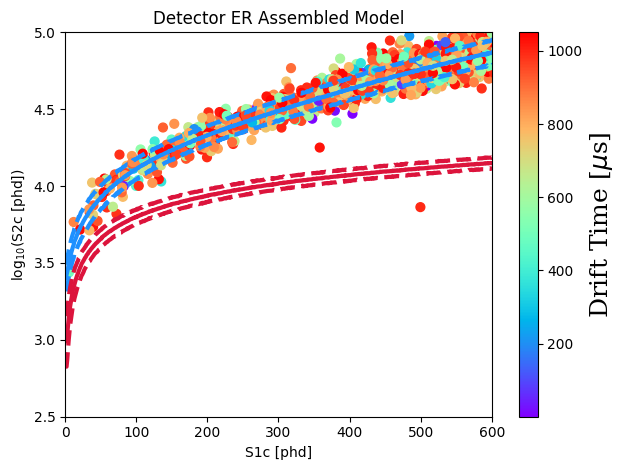

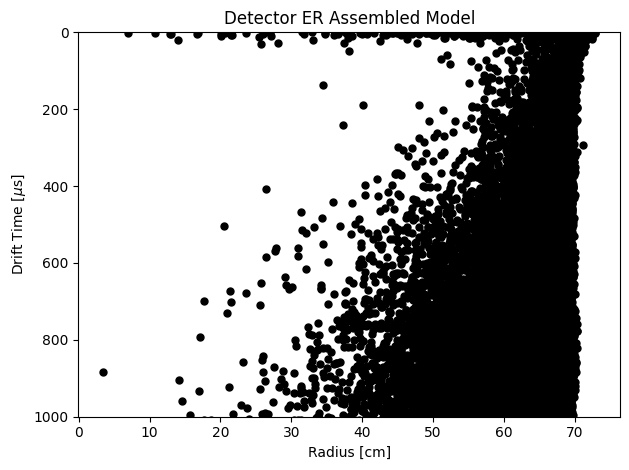

In [6]:
sc = plt.scatter(
    ss["ss.correctedS1Area_phd"],
    np.log10(ss["ss.correctedS2Area_phd"]),
    c=ss["ss.driftTime_ns"] / 1000.0,
    s=40,
    cmap="rainbow",
)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel(r"Drift Time [$\mu$s]", fontname="serif", fontsize=18)

plt.xlabel("S1c [phd]")
plt.ylabel(r"log$_{10}$(S2c [phd])")
plt.title("Detector ER Assembled Model")
plotBeta(True)
plotNR(True)
plt.xlim(0, 600)
plt.ylim(2.5, 5.0)
plt.tight_layout()
plt.savefig("DetER_AssembledModel_S1c_logS2c_drift.png", dpi=400)
plt.show()


plt.plot(
    np.sqrt(ss["ss.x_cm"] * ss["ss.x_cm"] + ss["ss.y_cm"] * ss["ss.y_cm"]),
    ss["ss.driftTime_ns"] / 1000.0,
    "k o",
    ms=5,
)
plt.ylim(1000, 0)
plt.xlabel(r"Radius [cm]")
plt.ylabel(r"Drift Time [$\mu$s]")
plt.title("Detector ER Assembled Model")

plt.tight_layout()
plt.savefig("DetER_AssembledModel_spatial.png", dpi=400)
plt.show()

[5.11755980e-01 4.39127174e+00 7.46771971e-04 2.99867308e+00]


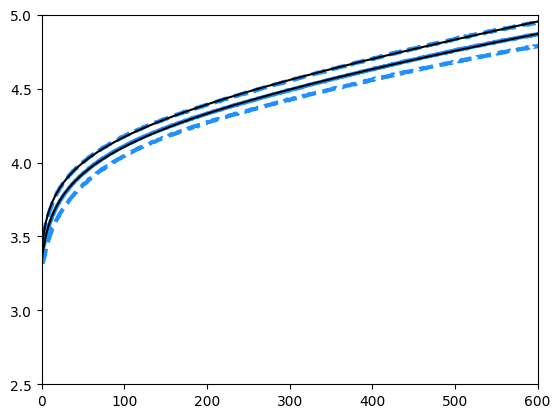

In [7]:
def Woods(x, a, b, c, d):
    return a * np.log10(x + b) + c * x + d


xBR, yBR, yHiBR = np.array(xBR), np.array(yBR), np.array(yHiBR)
cut = xBR < 600.0
medians, pcov = curve_fit(Woods, xBR[cut], yBR[cut], p0=[0.5, 5, 0.1, 5])
hiLine, pcov = curve_fit(Woods, xBR[cut], yHiBR[cut], p0=[0.5, 5, 0.1, 5])

s = np.linspace(0, 600, 1000)
fit, fitHi = Woods(s, *medians), Woods(s, *hiLine)
print(medians)
plotBeta(False)
plt.plot(s, fit, "k")
plt.plot(s, fitHi, "k")
plt.xlim(0, 600)
plt.ylim(2.5, 5)
plt.show()


muER = Woods(ss["ss.correctedS1Area_phd"], *medians)
sigER = Woods(ss["ss.correctedS1Area_phd"], *hiLine) - muER

below = np.log10(ss["ss.correctedS2Area_phd"]) < muER - 3.0 * sigER
above = np.log10(ss["ss.correctedS2Area_phd"]) > muER + 3.0 * sigER
inBand = (np.log10(ss["ss.correctedS2Area_phd"]) < muER + 3.0 * sigER) & (
    np.log10(ss["ss.correctedS2Area_phd"]) > muER - 3.0 * sigER
)

387 0 129


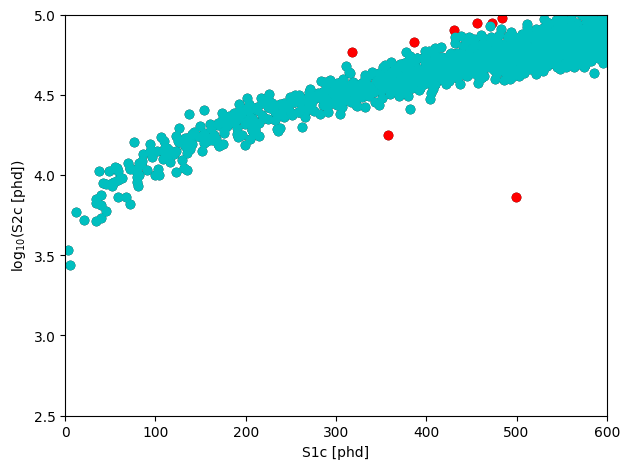

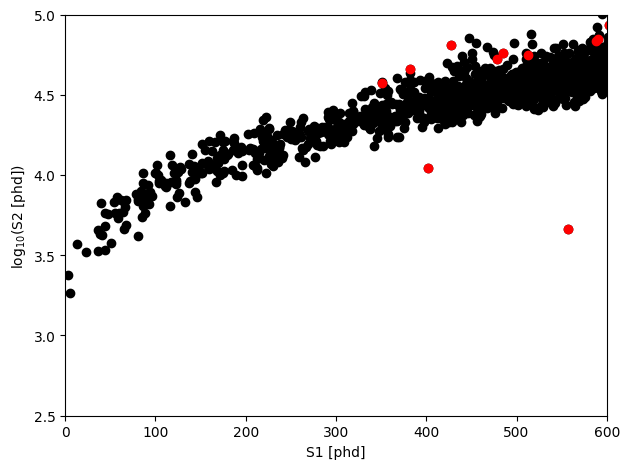

False


In [8]:
roi = np.log10(ss["ss.correctedS2Area_phd"]) < 4.5

plt.plot(ss["ss.correctedS1Area_phd"], np.log10(ss["ss.correctedS2Area_phd"]), "k o")
plt.plot(
    ss["ss.correctedS1Area_phd"][above],
    np.log10(ss["ss.correctedS2Area_phd"][above]),
    "r o",
)
plt.plot(
    ss["ss.correctedS1Area_phd"][below],
    np.log10(ss["ss.correctedS2Area_phd"][below]),
    "r o",
)
plt.plot(
    ss["ss.correctedS1Area_phd"][inBand],
    np.log10(ss["ss.correctedS2Area_phd"][inBand]),
    "c o",
)

print(
    len(ss["ss.correctedS1Area_phd"][roi]),
    len(ss["ss.correctedS1Area_phd"][above & roi]),
    len(ss["ss.correctedS1Area_phd"][below & roi]),
)
plt.xlabel("S1c [phd]")
plt.ylabel(r"log$_{10}$(S2c [phd])")

plt.xlim(0, 600)
plt.ylim(2.5, 5.0)
plt.tight_layout()
plt.show()


plt.plot(ss["ss.s1Area_phd"], np.log10(ss["ss.s2Area_phd"]), "k o")
plt.plot(ss["ss.s1Area_phd"][above], np.log10(ss["ss.s2Area_phd"][above]), "r o")
plt.plot(ss["ss.s1Area_phd"][below], np.log10(ss["ss.s2Area_phd"][below]), "r o")
plt.xlabel("S1 [phd]")
plt.ylabel(r"log$_{10}$(S2 [phd])")

plt.xlim(0, 600)
plt.ylim(2.5, 5.0)
plt.tight_layout()
plt.show()
print(inBand[0])

In [7]:
type(ss["ss.correctedS1Area_phd"])

awkward.highlevel.Array

In [158]:
is_mssi = np.zeros(len(ss["ss.correctedS1Area_phd"]), dtype=int)
is_GXe_mssi = np.zeros(len(ss["ss.correctedS1Area_phd"]), dtype=int)
has_GXe_S2 = np.zeros(len(ss["ss.correctedS1Area_phd"]), dtype=int)

total_Edep = []
total_S1_Edep = []
mssi_S1_R, mssi_S1_Z = [], []
mssi_S2_R, mssi_S2_Z = [], []
parent_R, parent_Z = [], []
all_fields, all_R, all_Z = [], [], []
detS1 = []
for i in tqdm.trange(len(is_mssi)):
    nS1, nS2 = 0, 0
    these_S1volumes = []
    these_S2volumes = []
    these_S1R, these_S1Z = [], []
    these_S2R, these_S2Z = [], []
    total_Edep.append(sum(mc["mcTruthVertices.energyDep_keV"][i]))
    thisS1_eDep = 0.0
    thisS1 = 0.0

    for j in range(mc["mcTruthVertices.nRQMCTruthVertices"][i]):

        if "Skin" in str(mc["mcTruthVertices.volumeName"][i][j]) or "Scint" in str(
            mc["mcTruthVertices.volumeName"][i][j]
        ):
            continue
        if mc["mcTruthVertices.detectedS1Photons"][i][j] > 0.0:
            nS1 += 1
            these_S1volumes.append(str(mc["mcTruthVertices.volumeName"][i][j]))
            these_S1R.append(
                pow(mc["mcTruthVertices.positionX_mm"][i][j], 2.0)
                + pow(mc["mcTruthVertices.positionY_mm"][i][j], 2.0)
            )
            these_S1Z.append(mc["mcTruthVertices.positionZ_mm"][i][j])
            thisS1_eDep += mc["mcTruthVertices.energyDep_keV"][i][j]
            thisS1 += mc["mcTruthVertices.detectedS1Photons"][i][j]
            if mc["mcTruthVertices.energyDep_keV"][i][j] > 2000.0:
                print(
                    mc["mcTruthVertices.energyDep_keV"][i][j],
                    mc["mcTruthVertices.detectedS1Photons"][i][j],
                    mc["mcTruthVertices.rawS1Photons"][i][j],
                    str(mc["mcTruthVertices.volumeName"][i][j]),
                )

        if mc["mcTruthVertices.detectedS2Photons"][i][j] > 0.0:
            nS2 += 1
            these_S2volumes.append(str(mc["mcTruthVertices.volumeName"][i][j]))
            these_S2R.append(
                pow(mc["mcTruthVertices.positionX_mm"][i][j], 2.0)
                + pow(mc["mcTruthVertices.positionY_mm"][i][j], 2.0)
            )
            these_S2Z.append(mc["mcTruthVertices.positionZ_mm"][i][j])
    total_S1_Edep.append(thisS1_eDep)
    detS1.append(thisS1)
    if nS1 > nS2:
        is_mssi[i] = 1
        mssi_S1_R.append(these_S1R)
        mssi_S2_R.append(these_S2R)
        mssi_S1_Z.append(these_S1Z)
        mssi_S2_Z.append(these_S2Z)
        # print("S1", these_S1volumes)
        # print("S2", these_S2volumes)
        # print( mc['mcTruthEvent.parentParticle'][i] )
        parent_R.append(
            pow(mc["mcTruthEvent.parentPositionX_mm"][i], 2.0)
            + pow(mc["mcTruthEvent.parentPositionY_mm"][i], 2.0)
        )
        parent_Z.append(mc["mcTruthEvent.parentPositionZ_mm"][i])

        for j in range(len(these_S1volumes)):
            if "GaseousXenon" in str(these_S1volumes[j]):
                is_GXe_mssi[i] = 1
                break
        for j in range(len(these_S2volumes)):
            if "GaseousXenon" in str(these_S2volumes[j]):
                has_GXe_S2[i] = 1
                break
    else:
        if inBand[i]:
            # print( "INBAND: ", mc['mcTruthEvent.parentParticle'][i] )
            for j in range(mc["mcTruthVertices.nRQMCTruthVertices"][i]):
                if "Skin" in str(
                    mc["mcTruthVertices.volumeName"][i][j]
                ) or "Scint" in str(mc["mcTruthVertices.volumeName"][i][j]):
                    continue
                if mc["mcTruthVertices.detectedS1Photons"][i][j] > 0.0:
                    all_R.append(
                        pow(mc["mcTruthVertices.positionX_mm"][i][j], 2.0)
                        + pow(mc["mcTruthVertices.positionY_mm"][i][j], 2.0)
                    )
                    all_Z.append(mc["mcTruthVertices.positionZ_mm"][i][j])
                    all_fields.append(
                        mc["mcTruthVertices.electricFieldStrength_Vcm"][i][j]
                    )


print("nMSSI = %i" % sum(is_mssi))

mssi = is_mssi > 0.5
gxe_mssi = is_GXe_mssi > 0.5
gxe_S2 = has_GXe_S2 > 0.5

100%|██████████| 84923/84923 [11:21<00:00, 124.59it/s]

nMSSI = 4185


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit

# import scipy.stats as s
import sys
import os
from scipy.special import erf, erfc
import random
import uproot as up
import tqdm
import numba
import awkward as ak

In [2]:
file = "/shared/scratch/ak18773/lz/mssi/SS_skim_Th232-late_HVInnerCone.root"

branches = [
    "ss.correctedS1Area_phd",
    "ss.correctedS2Area_phd",
    "ss.s1Area_phd",
    "ss.s2Area_phd",
    "ss.x_cm",
    "ss.y_cm",
    "ss.driftTime_ns",
]
mcBranches = [
    "mcTruthVertices.nRQMCTruthVertices",
    "mcTruthVertices.electricFieldStrength_Vcm",
    "mcTruthVertices.detectedS1Photons",
    "mcTruthVertices.detectedS2Photons",
    "mcTruthVertices.rawS1Photons",
    "mcTruthVertices.rawS2Photons",
    "mcTruthVertices.volumeName",
    "mcTruthVertices.positionX_mm",
    "mcTruthVertices.positionY_mm",
    "mcTruthVertices.positionZ_mm",
    "mcTruthVertices.energyDep_keV",
    "mcTruthVertices.pid",
    "mcTruthEvent.parentParticle",
    "mcTruthEvent.parentPositionX_mm",
    "mcTruthEvent.parentPositionY_mm",
    "mcTruthEvent.parentPositionZ_mm",
]

t = up.open(file)["Scatters"]
mct = up.open(file)["RQMCTruth"]

ss = t.arrays(branches)
mc = mct.arrays(mcBranches)

print(len(ss["ss.correctedS1Area_phd"]), len(mc["mcTruthVertices.nRQMCTruthVertices"]))

84923 84923


In [9]:
@numba.njit
def process_event(ss, mc, inBand):
    is_mssi = np.zeros(len(ss["ss.correctedS1Area_phd"]))
    is_GXe_mssi = np.zeros(len(ss["ss.correctedS1Area_phd"]))
    has_GXe_S2 = np.zeros(len(ss["ss.correctedS1Area_phd"]))

    total_Edep = []
    total_S1_Edep = []
    mssi_S1_R = []
    mssi_S1_Z = []
    mssi_S2_R = []
    mssi_S2_Z = []
    parent_R = []
    parent_Z = []
    all_fields = []
    all_R = []
    all_Z = []
    detS1 = []
    for i in range(len(is_mssi)):
        nS1 = 0
        nS2 = 0
        thisS1_eDep = 0.0
        thisS1 = 0.0
        these_S1volumes = []
        these_S2volumes = []
        these_S1R = []
        these_S1Z = []
        these_S2R = []
        these_S2Z = []
        thisEdep = 0
        for val in mc["mcTruthVertices.energyDep_keV"][i]:
            thisEdep += val
        total_Edep.append(thisEdep)

        for j in range(mc["mcTruthVertices.nRQMCTruthVertices"][i]):
            if "Skin" in str(mc["mcTruthVertices.volumeName"][i][j]) or "Scint" in str(
                mc["mcTruthVertices.volumeName"][i][j]
            ):
                continue
            if mc["mcTruthVertices.detectedS1Photons"][i][j] > 0.0:
                nS1 += 1
                these_S1volumes.append(str(mc["mcTruthVertices.volumeName"][i][j]))
                these_S1R.append(
                    pow(mc["mcTruthVertices.positionX_mm"][i][j], 2.0)
                    + pow(mc["mcTruthVertices.positionY_mm"][i][j], 2.0)
                )
                these_S1Z.append(mc["mcTruthVertices.positionZ_mm"][i][j])
                thisS1_eDep += mc["mcTruthVertices.energyDep_keV"][i][j]
                thisS1 += mc["mcTruthVertices.detectedS1Photons"][i][j]
                if mc["mcTruthVertices.energyDep_keV"][i][j] > 2000.0:
                    print(
                        mc["mcTruthVertices.energyDep_keV"][i][j],
                        mc["mcTruthVertices.detectedS1Photons"][i][j],
                        mc["mcTruthVertices.rawS1Photons"][i][j],
                        str(mc["mcTruthVertices.volumeName"][i][j]),
                    )
            if mc["mcTruthVertices.detectedS2Photons"][i][j] > 0.0:
                nS2 += 1
                these_S2volumes.append(str(mc["mcTruthVertices.volumeName"][i][j]))
                these_S2R.append(
                    pow(mc["mcTruthVertices.positionX_mm"][i][j], 2.0)
                    + pow(mc["mcTruthVertices.positionY_mm"][i][j], 2.0)
                )
                these_S2Z.append(mc["mcTruthVertices.positionZ_mm"][i][j])
        total_S1_Edep.append(thisS1_eDep)
        detS1.append(thisS1)
        if nS1 > nS2:
            is_mssi[i] = 1
            mssi_S1_R.append(these_S1R)
            mssi_S2_R.append(these_S2R)
            mssi_S1_Z.append(these_S1Z)
            mssi_S2_Z.append(these_S2Z)
            parent_R.append(
                pow(mc["mcTruthEvent.parentPositionX_mm"][i], 2.0)
                + pow(mc["mcTruthEvent.parentPositionY_mm"][i], 2.0)
            )
            parent_Z.append(mc["mcTruthEvent.parentPositionZ_mm"][i])

            for j in range(len(these_S1volumes)):
                if "GaseousXenon" in str(these_S1volumes[j]):
                    is_GXe_mssi[i] = 1
                    break
            for j in range(len(these_S2volumes)):
                if "GaseousXenon" in str(these_S2volumes[j]):
                    has_GXe_S2[i] = 1
                    break
        else:
            if inBand[i]:
                for j in range(mc["mcTruthVertices.nRQMCTruthVertices"][i]):
                    if "Skin" in str(
                        mc["mcTruthVertices.volumeName"][i][j]
                    ) or "Scint" in str(mc["mcTruthVertices.volumeName"][i][j]):
                        continue
                    if mc["mcTruthVertices.detectedS1Photons"][i][j] > 0.0:
                        all_R.append(
                            pow(mc["mcTruthVertices.positionX_mm"][i][j], 2.0)
                            + pow(mc["mcTruthVertices.positionY_mm"][i][j], 2.0)
                        )
                        all_Z.append(mc["mcTruthVertices.positionZ_mm"][i][j])
                        all_fields.append(
                            mc["mcTruthVertices.electricFieldStrength_Vcm"][i][j]
                        )

    return (
        is_mssi,
        is_GXe_mssi,
        has_GXe_S2,
        total_Edep,
        total_S1_Edep,
        mssi_S1_R,
        mssi_S1_Z,
        mssi_S2_R,
        mssi_S2_Z,
        parent_R,
        parent_Z,
        all_fields,
        all_R,
        all_Z,
        detS1,
    )

In [10]:
(
    is_mssi,
    is_GXe_mssi,
    has_GXe_S2,
    total_Edep,
    total_S1_Edep,
    mssi_S1_R,
    mssi_S1_Z,
    mssi_S2_R,
    mssi_S2_Z,
    parent_R,
    parent_Z,
    all_fields,
    all_R,
    all_Z,
    detS1,
) = process_event(ss, mc, inBand)
print(sum(is_mssi))

4185.0
